In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os

In [17]:
def vegetation(df, show=True):
    df.dropna(inplace=True)
    def water_balance(P, EP, Si_max):

        Si = np.zeros(len(P))
        Pe = np.zeros(len(P))
        for i in range(1, len(P)):
            Si[i] = Si[i-1] + P[i] 
            

            if Si[i] > Si_max:
                Pe[i] = Si[i] - Si_max
                Si[i] = Si[i] - Pe[i]

            Si[i] = Si[i] - EP[i]
            if Si[i] < 0:
                Si[i] = 0

        df = pd.DataFrame()
        df['P'] = P
        df['EP'] = EP
        df['Si'] = Si
        df['Pe'] = Pe
        return df
    
    Si_max = 2.5 # mm
    df_wb = water_balance(df.P, df.Pev, Si_max)
    
    
    fig, ax = plt.subplots(2, figsize=(10,6))
    df_wb['P'].plot(ax=ax[1])
    df_wb['Pe'].plot(ax=ax[1])
    ax[1].set_xlabel('Date')
    ax[1].set_title('Interception')
    ax[1].legend()
    fig.tight_layout(h_pad=4)
    df_data.plot(ax=ax[0], xlabel='Date')

    mean_P = df_wb['P'].mean()
    mean_Pe = df_wb['Pe'].mean()
    ratio = mean_Pe / mean_P
    
    if show != True:
        plt.close()
        
    return ratio, df_wb


In [18]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'

In [19]:
files = glob.glob(f"{data_folder}\\*.parquet")
files

['C:\\Users\\anne-\\OneDrive - Delft University of Technology\\Documenten\\Environmental Engineering MSc\\ENVM1502-Catchment-model\\Data\\combined_data.parquet']

In [20]:
df_data = pd.read_parquet(files[0])

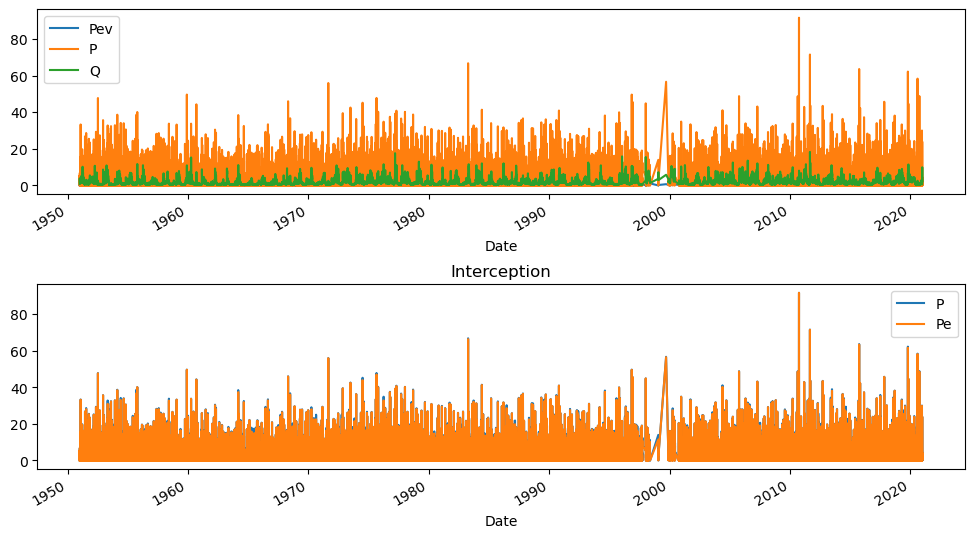

In [21]:
ratio, df = vegetation(df_data)

In [30]:
def plant_transpiration(df, show=True):
    from datetime import date, timedelta
    df.dropna(inplace=True)
    
    P_mean = df['P'].mean()
    Q_mean = df['Q'].mean()
    Et_dash = P_mean - Q_mean
    EP_mean = df['Pev'].mean()
    
    df['Et'] = df['Pev'] / EP_mean * Et_dash
    df['Sd'] = np.zeros(len(df['P']))
    
    cumsum = 0 
    
    for i in range(len(df['Et'])):
        cumsum += (df['P'].iloc[i] - df['Et'].iloc[i])
        if cumsum > 0:
            cumsum = 0
        df['Sd'].iloc[i] = np.minimum(0, cumsum)
    
    unique_years = len(df.index.year.unique())
    
    Sr = min(df['Sd'])
    Sr_index = df['Sd'].idxmin()
    
    EP_P = EP_mean / P_mean
    Et_P =  df['Et'].mean() / P_mean
    
    fig, ax = plt.subplots(2,figsize=(8,8))
    fig.tight_layout(h_pad=4)
    ax2 = ax[0].twinx()  
    df['P'].plot(ax=ax[0], label='Precipitation')
    df['Pev'].plot(ax=ax2, color='C1', label='Evaporation')
    
    ax[0].legend()
    ax2.legend()
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('mm/d');
    
    df['Sd'].plot(ax=ax[1])
    ax[1].plot(Sr_index, Sr, 'ro')
    ax[1].text(Sr_index+timedelta(100), Sr, f'SR,{unique_years}y', fontsize=9)
    ax[1].legend()
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Storage deficit');
    
    if show == True:
        print(f'The vegetation-accessible water storage volume (or root-zone storage capacity) SR,y is {-Sr:.2f} [mm] over the preceding {unique_years} years')
    else:
        plt.close()
    
    return df, Sr, Et_P, EP_P

C:\Users\anne-\AppData\Local\Temp\ipykernel_25752\76820886.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sd'].iloc[i] = np.minimum(0, cumsum)


The vegetation-accessible water storage volume (or root-zone storage capacity) SR,y is 111.15 [mm] over the preceding 70 years


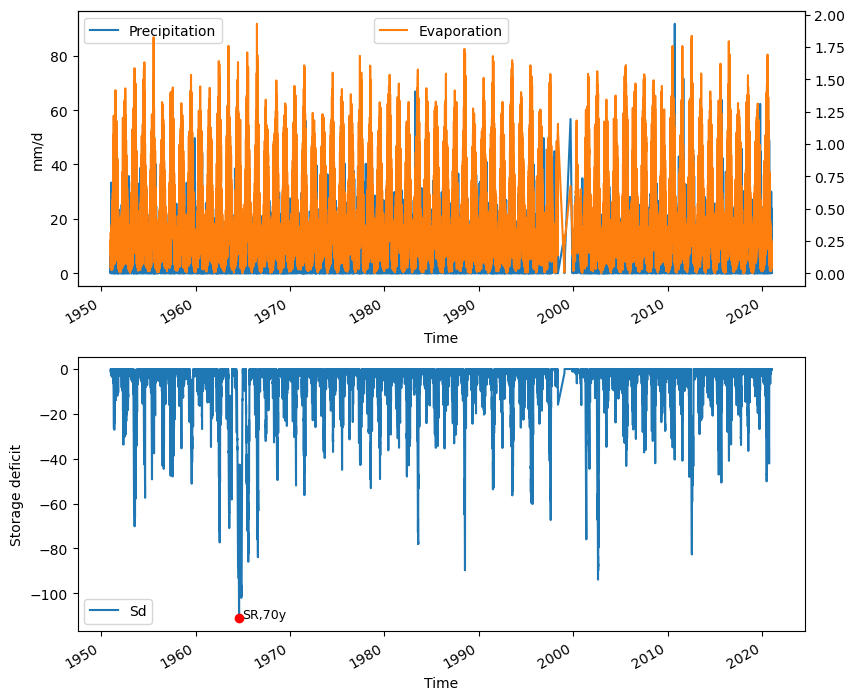

In [31]:
df, Sr, Et_P, EP_P = plant_transpiration(df_data)